In [1]:
from pyDeepInsight import ImageTransformer, LogScaler
import pandas as pd
import numpy as np
import pickle
import anndata
import random
from sklearn.manifold import TSNE
from sklearn import preprocessing
from timeit import default_timer as timer
import scanpy as sc

In [2]:
reference = anndata.read_h5ad("reference.h5ad")

In [3]:
reference.X = reference.raw.X

In [4]:
#Normalize without batch effect correction
sc.pp.filter_genes(reference, min_counts=1) 
sc.pp.highly_variable_genes(reference, n_top_genes=3000, flavor="seurat_v3")
reference = reference[:,reference.var["highly_variable"] == True]
sc.pp.normalize_per_cell(reference)
sc.pp.log1p(reference)

/home/shangru/miniconda3/envs/sr/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [5]:
min_max_scaler = preprocessing.MinMaxScaler()
scaled = pd.DataFrame(np.asarray(reference.X.toarray()))
scaled = min_max_scaler.fit_transform(scaled)
scaled = pd.DataFrame(scaled)
scaled.index = reference.obs.index.values
scaled.columns = reference.var.index.values
scaled

,ENSG00000188290,ENSG00000187608,ENSG00000186891,ENSG00000186827,ENSG00000162576,ENSG00000196581,ENSG00000049249,ENSG00000142583,ENSG00000162444,ENSG00000142657,...,ENSG00000165349,ENSG00000254968,ENSG00000100968,ENSG00000121440,ENSG00000113361,ENSG00000225752,ENSG00000186652,ENSG00000232591,ENSG00000261082,ENSG00000282602
L1_AAACCCAAGAAACTCA,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.188740,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L1_AAACCCAAGACATACA,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L1_AAACCCACAACTGGTT,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L1_AAACCCACACGTACTA,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L1_AAACCCACAGCATACT,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E2L8_TTTGTTGGTCGTGATT,0.000000,0.173272,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E2L8_TTTGTTGGTGTGCCTG,0.103185,0.056782,0.0,0.000000,0.0,0.0,0.0,0.0,0.186843,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E2L8_TTTGTTGGTTAGTTCG,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E2L8_TTTGTTGGTTGGCTAT,0.080277,0.167955,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.215884,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
reference.var.to_csv("./pretrained/pretrained_genes.csv")

In [7]:
#Get cell-type information from initial reference dataset
ref = anndata.read_h5ad("reference.h5ad")
obs = ref.obs.loc[scaled.index.tolist()]
scaled["celltype_l2"] = obs["celltype.l2"]
tags = scaled['celltype_l2'].unique().tolist()
train_ls = []
val_ls = []
test_ls = []
#Split dataset into training dataset, validation dataset and test dataset by 90:5:5
for tag in tags:
    df = pd.DataFrame(scaled[(scaled['celltype_l2'] == tag)].index.values)
    train_part = df.sample(frac=0.90)[0].tolist()
    df = df[~df[0].isin(train_part)]
    val_part = df.sample(frac=0.50)[0].tolist()
    df = df[~df[0].isin(val_part)]
    test_part = df.sample(frac=1.0)[0].tolist()
    train_ls = train_ls + train_part
    val_ls = val_ls + val_part
    test_ls = test_ls + test_part
    
train_rna = scaled.loc[train_ls]
val_rna = scaled.loc[val_ls]
test_rna = scaled.loc[test_ls]

train_rna

,ENSG00000188290,ENSG00000187608,ENSG00000186891,ENSG00000186827,ENSG00000162576,ENSG00000196581,ENSG00000049249,ENSG00000142583,ENSG00000162444,ENSG00000142657,...,ENSG00000254968,ENSG00000100968,ENSG00000121440,ENSG00000113361,ENSG00000225752,ENSG00000186652,ENSG00000232591,ENSG00000261082,ENSG00000282602,celltype_l2
L3_CTCCAACTCAGACATC,0.000000,0.124812,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CD14 Mono
E2L3_ACAACCAAGCCAGAGT,0.000000,0.055011,0.000000,0.000000,0.0,0.0,0.0,0.0,0.309680,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CD14 Mono
E2L1_CCAATGAGTCCTTAAG,0.118258,0.034716,0.000000,0.000000,0.0,0.0,0.0,0.0,0.211524,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CD14 Mono
E2L5_TAGGTACCAGAGGTTG,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.442924,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CD14 Mono
E2L5_TGGCGTGCACGAGGTA,0.000000,0.120749,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.12856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CD14 Mono
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E2L8_GTCATTTCACAGTATC,0.000000,0.314421,0.264157,0.470482,0.0,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ILC
L4_TGCAGATAGCACTCAT,0.000000,0.000000,0.639894,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ILC
L5_TCACGCTAGCCATCCG,0.401485,0.411604,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ILC
E2L8_GGCTTGGTCAAGTAAG,0.000000,0.000000,0.206551,0.382945,0.0,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ILC


In [8]:
#Store cell-type information in this step for further training
pd.DataFrame(train_rna["celltype_l2"]).to_csv("./pretrained/trainy_pre.csv")
pd.DataFrame(val_rna["celltype_l2"]).to_csv("./pretrained/valy_pre.csv")
pd.DataFrame(test_rna["celltype_l2"]).to_csv("./pretrained/testy_pre.csv")

/home/shangru/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


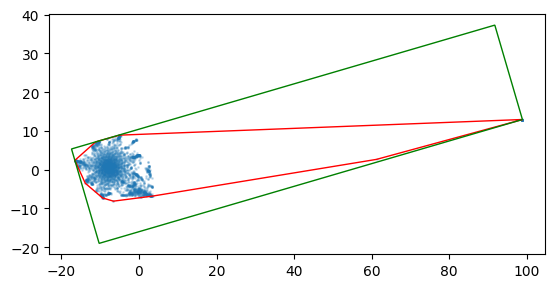

In [9]:
start = timer()
tsne = TSNE(n_components=2, perplexity=50, metric='euclidean', random_state=0, n_jobs=-1, learning_rate="auto", init='pca')
it = ImageTransformer(feature_extractor=tsne, pixels=224, random_state=0, n_jobs=-1)
it.fit(train_rna.iloc[:, :-1], plot=True)
#save image transformer
with open("/Usersdata/shangru/docker/pretrained/img_transformer_pre.obj","wb") as f:
    pickle.dump(it, f)

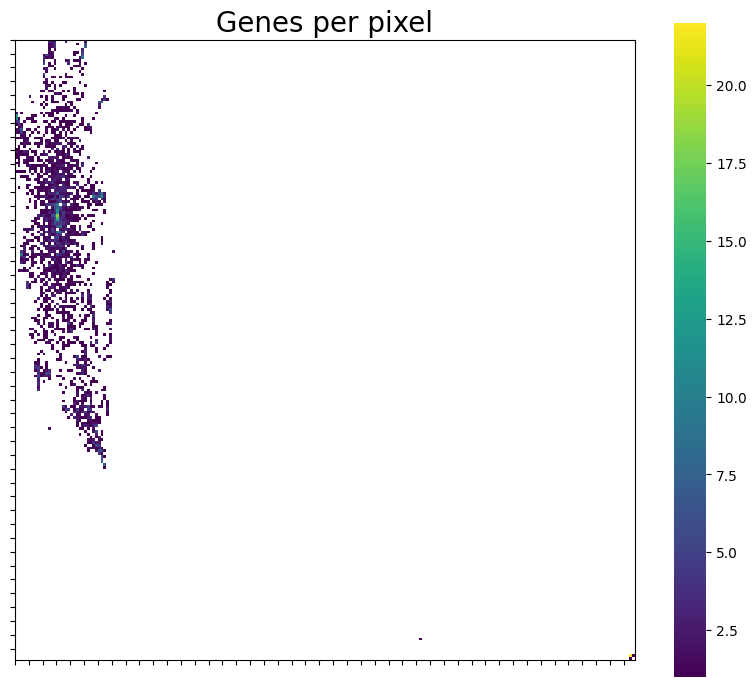

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

fdm = it.feature_density_matrix()
fdm[fdm == 0] = np.nan

plt.figure(figsize=(10, 8.5))

ax = sns.heatmap(fdm, cmap="viridis", linewidths=0., 
                 linecolor="lightgrey", square=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
for _, spine in ax.spines.items():
    spine.set_visible(True)
_ = plt.title("Genes per pixel", fontsize = 20)

In [11]:
#Transform non-image processed datasets into images
rna_list = np.array_split(train_rna, 4)
#Split the dataset to avoid memory problems
rna1 = rna_list[0]
img_1 = (it.transform(rna1.iloc[:, :-1])*255).astype(np.uint8)
rna2 = rna_list[1]
img_2 = (it.transform(rna2.iloc[:, :-1])*255).astype(np.uint8)
rna3 = rna_list[2]
img_3 = (it.transform(rna3.iloc[:, :-1])*255).astype(np.uint8)
rna4 = rna_list[3]
img_4 = (it.transform(rna4.iloc[:, :-1])*255).astype(np.uint8)

train_img = np.concatenate((img_1, img_2, img_3, img_4), axis=0)
val_img = (it.transform(val_rna.iloc[:, :-1])*255).astype(np.uint8)
test_img = (it.transform(test_rna.iloc[:, :-1])*255).astype(np.uint8)

#Calculate the time consume in the image convertion process
end = timer()
print(end - start)

508.73370100324973


In [12]:
#Store processed images in npy format
path1 = '/Usersdata/shangru/docker/pretrained/train_pre.npy'
path2 = '/Usersdata/shangru/docker/pretrained/val_pre.npy'
path3 = '/Usersdata/shangru/docker/pretrained/query_pre.npy'

np.save(path1, train_img)
np.save(path2, val_img)
np.save(path3, test_img)